In [1]:
from google.cloud.storage import Client
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt

### Examples as annual time series

In [2]:
import os

client = Client(project="forest-lst")
bucket = "forest-lst-test-export"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="ca_all_features_label")
    if ".tfrecord" in f.name
]

print("\n".join(records))

gs://forest-lst-test-export/ca_all_features_label/2016/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2016/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2016/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00002.tfrecord


In [3]:
from google.protobuf import json_format
import json
from IPython.display import JSON

ds = tf.data.TFRecordDataset(records)

raw_record = next(ds.take(1).as_numpy_iterator())
example = tf.train.Example()
example.ParseFromString(raw_record)
m = json.loads(json_format.MessageToJson(example))
JSON(m)

<IPython.core.display.JSON object>

In [4]:
def decode_record(proto):
    spec = {
        "SEVERITY": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "latitude": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "longitude": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "elevation": tf.io.FixedLenFeature([1], dtype=tf.int64),
        "is_cloudy": tf.io.FixedLenFeature([1], dtype=tf.string),
        "prcp": tf.io.FixedLenFeature([365], dtype=tf.float32),
        "dT": tf.io.FixedLenFeature([46], dtype=tf.float32)
    }

    ex = tf.io.parse_single_example(proto, spec)

    # I'm not sure why we have to make this cast but we do
    ex["is_cloudy"] = tf.squeeze(tf.io.decode_raw(ex["is_cloudy"], tf.uint8))

    return ex

def empty_record(record):
    return tf.math.count_nonzero(record["longitude"]) > 0

ds_dec = ds.map(decode_record).filter(empty_record)

feature = next(ds_dec.take(1).as_numpy_iterator())

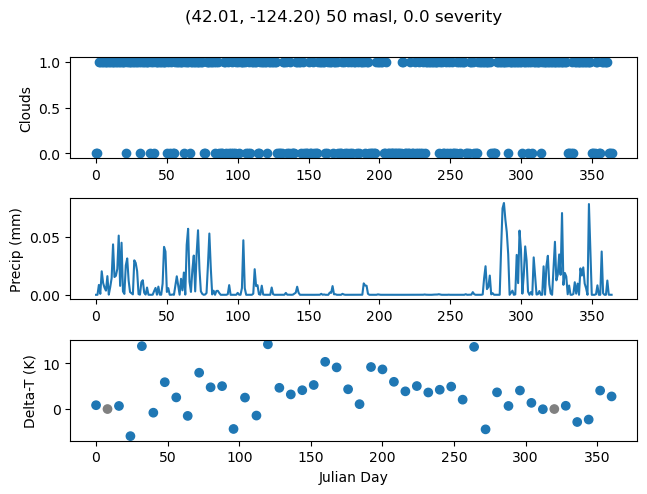

In [5]:
def plot_annual_feature(feature):
    xax_365 = np.arange(0, 365)
    xax_46  = np.arange(0, 46) * 8
    
    fig, ax = plt.subplots(nrows=3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    ax[0].scatter(xax_365, feature["is_cloudy"])
    ax[0].set_ylabel("Clouds")
    
    ax[1].plot(xax_365, feature["prcp"])
    ax[1].set_ylabel("Precip (mm)")
    
    ax[2].scatter(xax_46, feature["dT"], c=np.where(feature["dT"] == 0, "gray", "#1f77b4"))
    ax[2].set_ylabel("Delta-T (K)")
    ax[2].set_xlabel("Julian Day")
    
    fig.suptitle("({:4.2f}, {:4.2f}) {} masl, {} severity".format(
        feature["latitude"][0], feature["longitude"][0], feature["elevation"][0], feature["SEVERITY"][0]
    )) 
    
    plt.show()

plot_annual_feature(feature)

### Examples as long-term data for one pixel

In [6]:
records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="ca_dense_tensors_v3/")
    if ".tfrecord" in f.name
]

print("Records found:", len(records))
print("Here are the first 10")
print("\n".join(records[:10]))

Records found: 43
Here are the first 10
gs://forest-lst-test-export/ca_dense_tensors_v3/tile0/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile1/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile10/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile11/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile12/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile13/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile14/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile15/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile16/00000.tfrecord
gs://forest-lst-test-export/ca_dense_tensors_v3/tile17/00000.tfrecord


In [7]:
ds_dense = tf.data.TFRecordDataset(records)

raw_record = next(ds_dense.take(1).as_numpy_iterator())
example = tf.train.Example()
example.ParseFromString(raw_record)
m = json.loads(json_format.MessageToJson(example))
JSON(m)

<IPython.core.display.JSON object>

In [8]:
feature_names = list(m["features"]["feature"].keys())
feature_ints = ["year", "elevation"]
feature_len   = len(m["features"]["feature"]["year"]["int64List"]["value"])

spec_dense = {
    key: tf.io.FixedLenFeature([feature_len], dtype=tf.int64 if key in feature_ints else tf.float32) 
    for key in feature_names
}

def decode_record_dense(proto):
    return tf.io.parse_single_example(proto, spec_dense)

ds_dense_dec = ds_dense.map(decode_record_dense).filter(empty_record)

In [9]:
# Find a feature with at least 5 data points
iter = ds_dense_dec.take(100).as_numpy_iterator()
feature = None
while True:
    feature = next(iter)
    if np.count_nonzero(feature["longitude"]) > 5:
        break

In [10]:
feature

{'EVI_p5': array([0.3153, 0.327 , 0.3123, 0.3434, 0.3517, 0.1371, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ], dtype=float32),
 'EVI_p50': array([0.37575, 0.3939 , 0.3936 , 0.4144 , 0.4333 , 0.3923 , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       dtype=float32),
 'EVI_p95': array([0.4461, 0.4465, 0.4527, 0.5031, 0.5033, 0.4381, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ], dtype=float32),
 'dT_p5': array([-5.03149  , -5.424439 , -5.0691304, -4.50387  , -5.1586804,
        -4.677048 ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ], dtype=float

In [11]:
def plot_dense_example(feature):
    # Drop years with missing data
    use_years = feature["year"] != 0
    feature_no_na = {key: feature[key][use_years] for key in feature}
    
    
    title = "({:.2f}, {:.2f})  {} masl".format(feature["latitude"][0], feature["longitude"][0], feature["elevation"][0])

    fig, ax = plt.subplots(nrows=5, figsize=(8, 8))

    # delta-T
    ax[0].scatter(feature_no_na["year"], feature_no_na["dT_p5"], c="blue")
    ax[0].scatter(feature_no_na["year"], feature_no_na["dT_p50"], c="green")
    ax[0].scatter(feature_no_na["year"], feature_no_na["dT_p95"], c="red")
    ax[0].set_ylabel("Delta-T (K)")

    # EVI
    ax[1].scatter(feature_no_na["year"], feature_no_na["EVI_p5"], c="blue")
    ax[1].scatter(feature_no_na["year"], feature_no_na["EVI_p50"], c="green")
    ax[1].scatter(feature_no_na["year"], feature_no_na["EVI_p95"], c="red")
    ax[1].set_ylabel("EVI")

    # SPEI
    ax[2].scatter(feature_no_na["year"], feature_no_na["spei30d_p5"], c="blue")
    ax[2].scatter(feature_no_na["year"], feature_no_na["spei30d_p50"], c="green")
    ax[2].scatter(feature_no_na["year"], feature_no_na["spei30d_p95"], c="red")
    ax[2].set_ylabel("SPEI")

    # Precip and minimum winter T
    ax_twin = ax[3].twinx()
    ax[3].scatter(feature_no_na["year"], feature_no_na["prcp"], c="blue")
    ax[3].set_ylabel("Precipitation (mm)")
    ax_twin.scatter(feature_no_na["year"], feature_no_na["winter_tmin"], c="green")
    ax_twin.set_ylabel("Winter Tmin (C)")

    # Mortality
    ax[4].scatter(feature_no_na["year"], feature_no_na["pct_mortality"])
    ax[4].set_ylabel("% Mortality")
    ax[4].set_xlabel("Year")

    # Cleanup
    fig.suptitle(title)
    fig.tight_layout()

    plt.show()

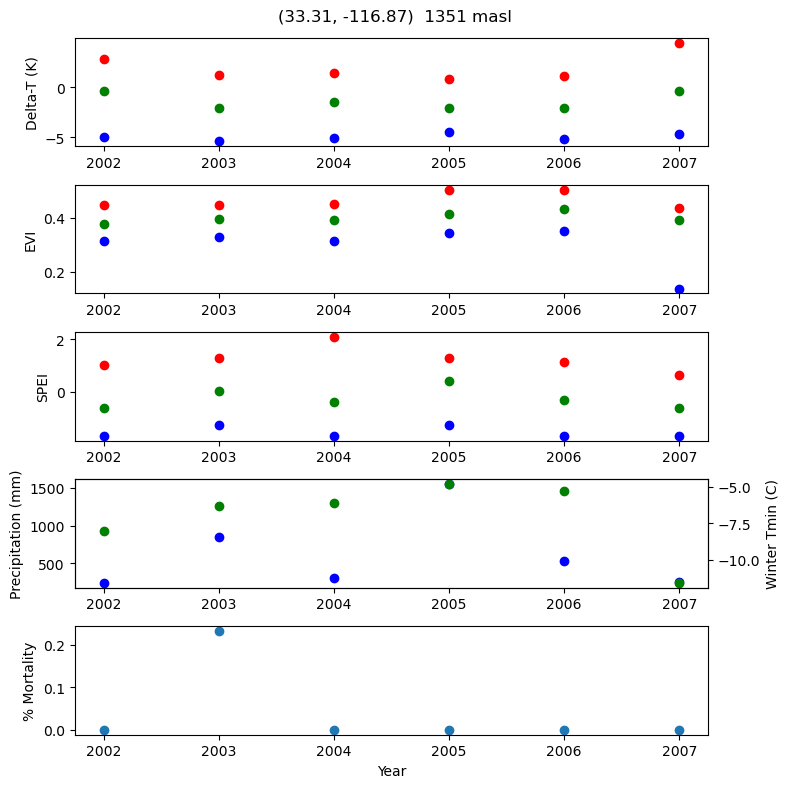

In [12]:
plot_dense_example(feature)

Number of non-empty pixels: 1126
Number of annual records: 8182


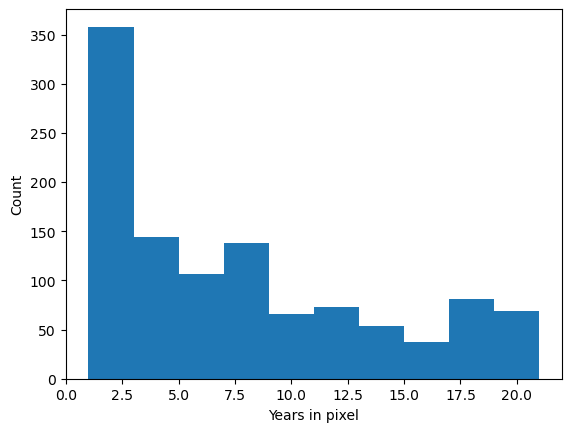

In [13]:
# How many non-empty pixels do we have, and how many usable years are in each one?
record_count = np.array([np.count_nonzero(f["longitude"]) for f in ds_dense_dec])

print("Number of non-empty pixels:", record_count.shape[0])
print("Number of annual records:", np.sum(record_count))

plt.hist(record_count)
plt.xlabel("Years in pixel")
plt.ylabel("Count")
plt.show()

In [14]:
# How many examples are available for different lookback periods?'
# Modified from:
# https://www.reddit.com/r/learnpython/comments/jsiubp/fastest_way_to_check_if_a_numpy_array_contains_n/
def positive_runs(arr, value):
    ones = np.ones_like(arr)
    np.bitwise_xor(arr[:-1], arr[1:], out=ones[1:])
    idxs = np.flatnonzero(ones)
    counts = np.diff(idxs, append=len(arr))
    counts_positive = counts[arr[idxs] == value]
    return counts_positive

def count_n_consecutive_values(arr, n, value):
    counts_positive = positive_runs(arr, value)
    return np.sum(np.maximum(counts_positive - n + 1, 0))

# Test it out
arr = np.array([True, True, True, False, True, True, False, False, False, True])

print("Lookback", "\t", "Count")
for i in range(1, len(arr)):
    print(i, "\t\t", count_n_consecutive_values(arr, i, True))

Lookback 	 Count
1 		 6
2 		 3
3 		 1
4 		 0
5 		 0
6 		 0
7 		 0
8 		 0
9 		 0


In [15]:
# Calculate available examples for each lookback
positive_counts = np.fromiter((positive_runs(f["longitude"] != 0, True) for f in ds_dense_dec.as_numpy_iterator()), dtype=object)

In [16]:
helper = lambda l: sum(np.sum(np.maximum(pc - l + 1, 0)) for pc in positive_counts)
available_examples = np.fromiter(map(helper, np.arange(2, 20)), dtype=int)

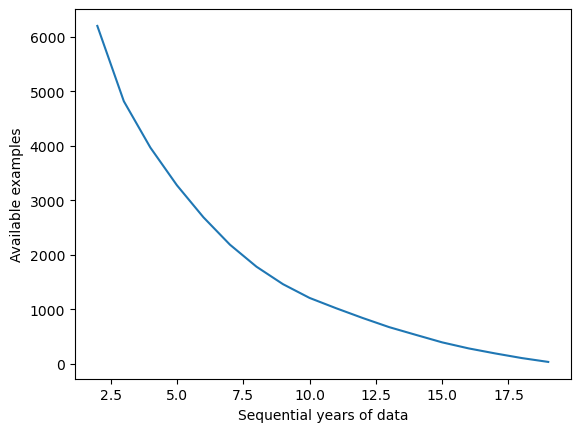

In [17]:
plt.plot(np.arange(2, 20), available_examples)
plt.xlabel("Sequential years of data")
plt.ylabel("Available examples")
plt.show()

In [27]:
# What is the distribution of mortality?
all_mort = np.hstack(np.fromiter((f["pct_mortality"][f["longitude"] != 0] for f in ds_dense_dec.as_numpy_iterator()), dtype=object))

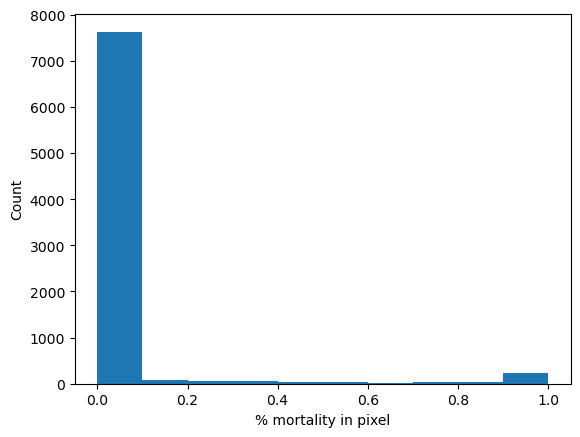

In [28]:
plt.hist(all_mort)
plt.xlabel("% mortality in pixel")
plt.ylabel("Count")
plt.show()